[INFO] Loading training data...
[INFO] Loaded 2858 images
[INFO] Loading test data...
[INFO] Loaded 187 images
[INFO] Training MLP...
[INFO] Predicting with MLP on test set...
MLP test results: {'accuracy': 0.31016042780748665, 'precision': 0.19557947900053163, 'recall': 0.18628787878787878, 'f1_score': 0.18866106507955033}
[INFO] Training KNN...
[INFO] Predicting with KNN on test set...
KNN test results: {'accuracy': 0.40641711229946526, 'precision': 0.2602098466505246, 'recall': 0.31287878787878787, 'f1_score': 0.2517305407011289}
[INFO] Training SVM...
[INFO] Predicting with SVM on test set...
SVM test results: {'accuracy': 0.44385026737967914, 'precision': 0.1827450980392157, 'recall': 0.21121212121212118, 'f1_score': 0.1561679012345679}


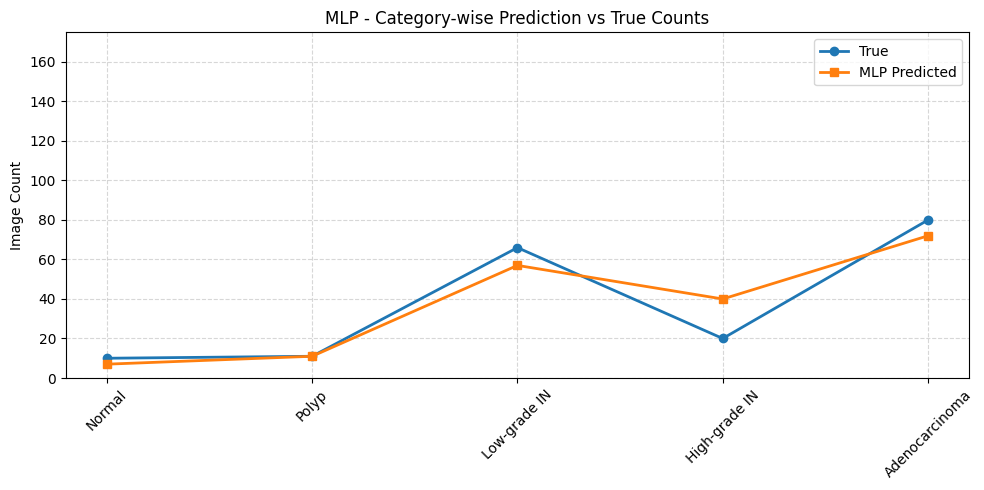

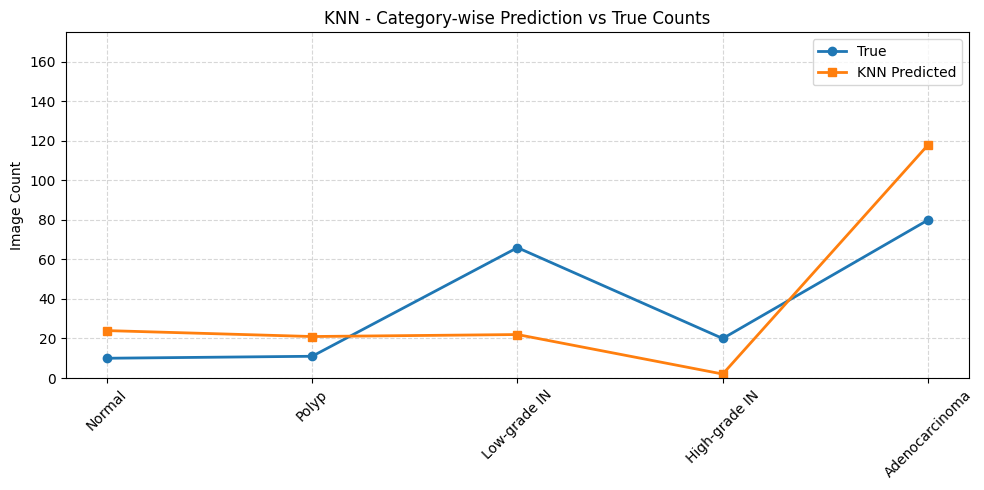

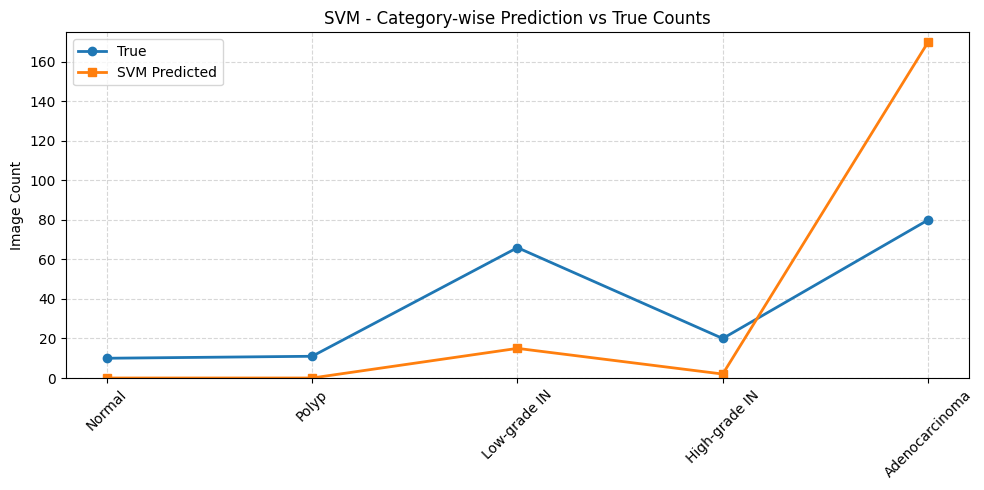

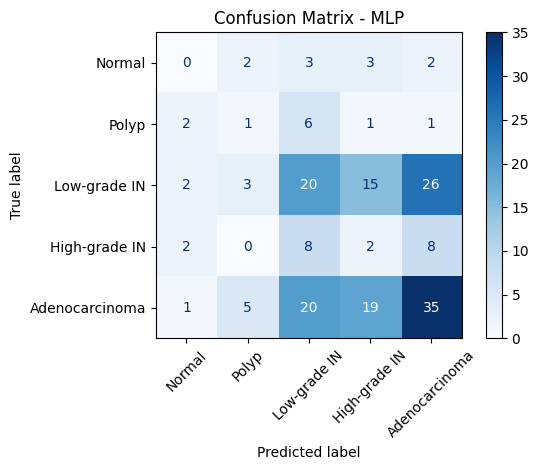

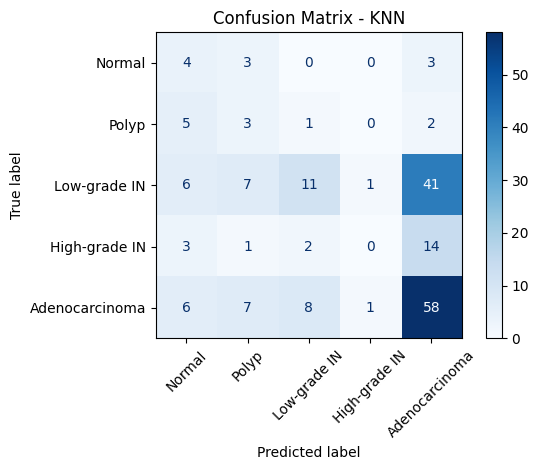

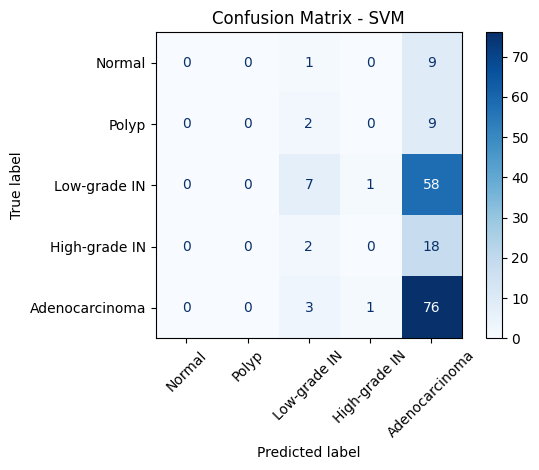

[INFO] Prediction results saved to 'prediction_results_details.csv'

Overall model performance comparison:
     accuracy  precision  recall  f1_score
MLP    0.3102     0.1956  0.1863    0.1887
KNN    0.4064     0.2602  0.3129    0.2517
SVM    0.4439     0.1827  0.2112    0.1562


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# === Configuration Class ===
class Config:
    CATEGORIES = ["Normal", "Polyp", "Low-grade IN", "High-grade IN", "Adenocarcinoma"]
    IMAGE_SIZE = (128, 128)
    BASE_DIR = "/Users/yishao/ColHis-IDS_split/train/200"
    TEST_DIR = "/Users/yishao/ColHis-IDS_split/test/200"

cfg = Config()

# === Feature Extraction ===
def extract_features(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    return hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)

def load_data(data_dir, categories, img_size=(128, 128)):
    X, y = [], []
    file_paths = []

    for label, cls in enumerate(categories):
        cls_folder = os.path.join(data_dir, cls)
        if not os.path.exists(cls_folder):
            print(f"[WARNING] Folder not found: {cls_folder}")
            continue

        for fname in os.listdir(cls_folder):
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(cls_folder, fname)
            try:
                image = imread(img_path, as_gray=True)
                image_resized = resize(image, img_size)
                features = extract_features(image_resized)
                X.append(features)
                y.append(label)
                file_paths.append(img_path)
            except Exception as e:
                print(f"[ERROR] Failed to process image {img_path}: {e}")

    print(f"[INFO] Loaded {len(X)} images")
    return np.array(X), np.array(y), file_paths

# === Visualization: Line Chart Per Model with Consistent Y Axis ===
def plot_individual_model_linecharts_with_fixed_ylim(y_test, predictions, categories):
    num_classes = len(categories)
    x = np.arange(num_classes)
    true_counts = np.bincount(y_test, minlength=num_classes)

    max_count = max(true_counts.max(), max(np.bincount(y_pred, minlength=num_classes).max() for y_pred in predictions.values()))
    y_limit = max_count + 5

    for model_name, y_pred in predictions.items():
        pred_counts = np.bincount(y_pred, minlength=num_classes)

        plt.figure(figsize=(10, 5))
        plt.plot(x, true_counts, marker='o', label='True', linewidth=2)
        plt.plot(x, pred_counts, marker='s', label=f'{model_name} Predicted', linewidth=2)

        plt.xticks(x, categories, rotation=45)
        plt.ylabel("Image Count")
        plt.ylim(0, y_limit)
        plt.title(f"{model_name} - Category-wise Prediction vs True Counts")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()

        filename = f"{model_name.lower()}_category_linechart_fixed_ylim.png"
        plt.savefig(filename, dpi=300)
        plt.show()

# === Plot Confusion Matrix ===
def plot_confusion_matrices(y_test, predictions, categories):
    for model_name, y_pred in predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.tight_layout()
        plt.savefig(f"{model_name.lower()}_confusion_matrix.png", dpi=300)
        plt.show()

# === Main Function ===
if __name__ == "__main__":
    print("[INFO] Loading training data...")
    X_train, y_train, _ = load_data(cfg.BASE_DIR, cfg.CATEGORIES, cfg.IMAGE_SIZE)

    print("[INFO] Loading test data...")
    X_test, y_test, test_files = load_data(cfg.TEST_DIR, cfg.CATEGORIES, cfg.IMAGE_SIZE)

    if len(X_train) == 0 or len(X_test) == 0:
        print("[ERROR] No data loaded. Please check your data directories.")
        exit(1)

    models = {
        'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, learning_rate_init=0.01, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    }

    predictions = {}
    metrics_results = {}

    for name, model in models.items():
        print(f"[INFO] Training {name}...")
        model.fit(X_train, y_train)

        print(f"[INFO] Predicting with {name} on test set...")
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        metrics_results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        print(f"{name} test results: {metrics_results[name]}")

    plot_individual_model_linecharts_with_fixed_ylim(y_test, predictions, cfg.CATEGORIES)
    plot_confusion_matrices(y_test, predictions, cfg.CATEGORIES)

    true_categories = [cfg.CATEGORIES[i] for i in y_test]
    prediction_data = {
        'File': [os.path.basename(f) for f in test_files],
        'True': true_categories
    }

    for name in models.keys():
        prediction_data[f'{name}_Pred'] = [cfg.CATEGORIES[i] for i in predictions[name]]
        prediction_data[f'{name}_Correct'] = [pred == true for pred, true in zip(predictions[name], y_test)]

    predictions_df = pd.DataFrame(prediction_data)
    predictions_df.to_csv('prediction_results_details.csv', index=False)
    print(f"[INFO] Prediction results saved to 'prediction_results_details.csv'")

    print("\nOverall model performance comparison:")
    results_df = pd.DataFrame(metrics_results).T
    print(results_df.round(4))


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# === Configuration Class ===
class Config:
    CATEGORIES = ["Normal", "Polyp", "Low-grade IN", "High-grade IN", "Adenocarcinoma"]
    IMAGE_SIZE = (224, 224)  # Standard size for most CNN models
    BASE_DIR = "/Users/yishao/ColHis-IDS_split/train/200"
    TEST_DIR = "/Users/yishao/ColHis-IDS_split/test/200"
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
cfg = Config()

# === Custom Dataset ===
class HistopathologyDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None):
        self.data_dir = data_dir
        self.categories = categories
        self.transform = transform
        self.file_paths = []
        self.labels = []
        
        for label, cls in enumerate(categories):
            cls_folder = os.path.join(data_dir, cls)
            if not os.path.exists(cls_folder):
                print(f"[WARNING] Folder not found: {cls_folder}")
                continue
                
            for fname in os.listdir(cls_folder):
                if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                    
                img_path = os.path.join(cls_folder, fname)
                self.file_paths.append(img_path)
                self.labels.append(label)
                
        print(f"[INFO] Loaded {len(self.file_paths)} images in dataset")
        
    def __len__(self):
        return len(self.file_paths)
        
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx], img_path
        except Exception as e:
            print(f"[ERROR] Failed to process image {img_path}: {e}")
            # Return a placeholder in case of error
            placeholder = torch.zeros((3, cfg.IMAGE_SIZE[0], cfg.IMAGE_SIZE[1]))
            return placeholder, self.labels[idx], img_path

# === Feature Extraction for Traditional ML ===
def extract_features(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    return hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)

def load_data(data_dir, categories, img_size=(128, 128)):
    X, y = [], []
    file_paths = []

    for label, cls in enumerate(categories):
        cls_folder = os.path.join(data_dir, cls)
        if not os.path.exists(cls_folder):
            print(f"[WARNING] Folder not found: {cls_folder}")
            continue

        for fname in os.listdir(cls_folder):
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(cls_folder, fname)
            try:
                image = imread(img_path, as_gray=True)
                image_resized = resize(image, img_size)
                features = extract_features(image_resized)
                X.append(features)
                y.append(label)
                file_paths.append(img_path)
            except Exception as e:
                print(f"[ERROR] Failed to process image {img_path}: {e}")

    print(f"[INFO] Loaded {len(X)} images")
    return np.array(X), np.array(y), file_paths

# === CNN Models ===
class AlexNetModel(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNetModel, self).__init__()
        # Features (convolutional layers)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class GoogleNetModel(nn.Module):
    def __init__(self, num_classes=5):
        super(GoogleNetModel, self).__init__()
        # Use a simplified model that captures the essence of GoogleNet/Inception
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)
        
        # Simplified Inception module
        self.inception3a = nn.Sequential(
            nn.Conv2d(192, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# === CNN Model Wrapper ===
class CNNModelWrapper:
    def __init__(self, model_name, num_classes):
        self.model_name = model_name
        self.num_classes = num_classes
        self.device = cfg.DEVICE
        try:
            self.model = self._create_model()
            self.model.to(self.device)
            print(f"[SUCCESS] Created {model_name} model")
        except Exception as e:
            print(f"[ERROR] Failed to create {model_name} model: {e}")
            raise
        
    def _create_model(self):
        # Handle model creation with fallbacks for problematic models
        if self.model_name == "ResNet50":
            # Using weights=None to avoid download issues, we'll train from scratch
            model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == "VGG16":
            model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=False)
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == "DenseNet":
            model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == "AlexNet":
            # Custom implementation without pretrained weights
            model = AlexNetModel(num_classes=self.num_classes)
        
        elif self.model_name == "GoogleNet":
            # Custom implementation without pretrained weights
            model = GoogleNetModel(num_classes=self.num_classes)
        
        elif self.model_name == "MobileNet":
            model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, self.num_classes)
        
        else:
            raise ValueError(f"Model {self.model_name} not supported")
            
        return model
    
    def fit(self, train_loader, epochs=3):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
        self.model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels, _ in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            accuracy = 100. * correct / total
            print(f'[INFO] {self.model_name} Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
    
    def predict(self, test_loader):
        self.model.eval()
        all_preds = []
        all_paths = []
        
        with torch.no_grad():
            for inputs, labels, paths in test_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = outputs.max(1)
                all_preds.extend(preds.cpu().numpy())
                all_paths.extend(paths)
                
        return np.array(all_preds), all_paths

# === Visualization: Line Chart Per Model with Consistent Y Axis ===
def plot_individual_model_linecharts_with_fixed_ylim(y_test, predictions, categories):
    num_classes = len(categories)
    x = np.arange(num_classes)
    true_counts = np.bincount(y_test, minlength=num_classes)

    max_count = max(true_counts.max(), max(np.bincount(y_pred, minlength=num_classes).max() for y_pred in predictions.values()))
    y_limit = max_count + 5

    for model_name, y_pred in predictions.items():
        pred_counts = np.bincount(y_pred, minlength=num_classes)

        plt.figure(figsize=(10, 5))
        plt.plot(x, true_counts, marker='o', label='True', linewidth=2)
        plt.plot(x, pred_counts, marker='s', label=f'{model_name} Predicted', linewidth=2)

        plt.xticks(x, categories, rotation=45)
        plt.ylabel("Image Count")
        plt.ylim(0, y_limit)
        plt.title(f"{model_name} - Category-wise Prediction vs True Counts")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()

        filename = f"{model_name.lower().replace(' ', '_')}_category_linechart_fixed_ylim.png"
        plt.savefig(filename, dpi=300)
        plt.show()

# === Plot Confusion Matrix ===
def plot_confusion_matrices(y_test, predictions, categories):
    for model_name, y_pred in predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
        
        plt.figure(figsize=(10, 8))
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.tight_layout()
        plt.savefig(f"{model_name.lower().replace(' ', '_')}_confusion_matrix.png", dpi=300)
        plt.show()

# === Main Function ===
if __name__ == "__main__":
    # Data transformation for CNN models
    transform = transforms.Compose([
        transforms.Resize(cfg.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets for CNN models
    train_dataset = HistopathologyDataset(cfg.BASE_DIR, cfg.CATEGORIES, transform=transform)
    test_dataset = HistopathologyDataset(cfg.TEST_DIR, cfg.CATEGORIES, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS)
    
    # For traditional ML models
    print("[INFO] Loading training data for traditional ML models...")
    X_train, y_train, _ = load_data(cfg.BASE_DIR, cfg.CATEGORIES, (128, 128))
    
    print("[INFO] Loading test data for traditional ML models...")
    X_test, y_test, test_files = load_data(cfg.TEST_DIR, cfg.CATEGORIES, (128, 128))
    
    if len(X_train) == 0 or len(X_test) == 0:
        print("[ERROR] No data loaded for traditional ML. Please check your data directories.")
    
    # Prepare all test labels
    test_labels = []
    for _, label, _ in test_dataset:
        test_labels.append(label)
    test_labels = np.array(test_labels)
    
    # Define all models to use
    traditional_models = {
        'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, learning_rate_init=0.01, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    }
    
    # Define CNN models with error handling
    cnn_models = {}
    model_names = ['ResNet50', 'VGG16', 'DenseNet', 'AlexNet', 'GoogleNet', 'MobileNet']
    
    for model_name in model_names:
        try:
            print(f"[INFO] Initializing {model_name}...")
            cnn_models[model_name] = CNNModelWrapper(model_name, len(cfg.CATEGORIES))
        except Exception as e:
            print(f"[ERROR] Failed to initialize {model_name}, skipping: {e}")
            continue
    
    predictions = {}
    metrics_results = {}
    
    # Train and evaluate traditional ML models
    for name, model in traditional_models.items():
        print(f"[INFO] Training {name}...")
        model.fit(X_train, y_train)
        
        print(f"[INFO] Predicting with {name} on test set...")
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        metrics_results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
        print(f"{name} test results: {metrics_results[name]}")
    
    # Train and evaluate CNN models
    for name, model in cnn_models.items():
        try:
            print(f"[INFO] Training {name}...")
            model.fit(train_loader, epochs=3)  # Reduced epochs for quicker testing
            
            print(f"[INFO] Predicting with {name} on test set...")
            y_pred, pred_paths = model.predict(test_loader)
            predictions[name] = y_pred
            
            accuracy = accuracy_score(test_labels, y_pred)
            precision = precision_score(test_labels, y_pred, average='macro', zero_division=0)
            recall = recall_score(test_labels, y_pred, average='macro', zero_division=0)
            f1 = f1_score(test_labels, y_pred, average='macro', zero_division=0)
            
            metrics_results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
            
            print(f"{name} test results: {metrics_results[name]}")
        except Exception as e:
            print(f"[ERROR] Failed to train or evaluate {name}: {e}")
            continue
    
    if len(predictions) > 0:
        # Visualizations
        plot_individual_model_linecharts_with_fixed_ylim(test_labels, predictions, cfg.CATEGORIES)
        plot_confusion_matrices(test_labels, predictions, cfg.CATEGORIES)
        
        # Save detailed prediction results to CSV
        true_categories = [cfg.CATEGORIES[i] for i in test_labels]
        
        # Get file paths from test dataset
        test_files = []
        for _, _, path in test_dataset:
            test_files.append(path)
        
        prediction_data = {
            'File': [os.path.basename(f) for f in test_files],
            'True': true_categories
        }
        
        for name in {**traditional_models, **cnn_models}.keys():
            if name in predictions:
                prediction_data[f'{name}_Pred'] = [cfg.CATEGORIES[i] for i in predictions[name]]
                prediction_data[f'{name}_Correct'] = [pred == true for pred, true in zip(predictions[name], test_labels)]
        
        predictions_df = pd.DataFrame(prediction_data)
        predictions_df.to_csv('prediction_results_details.csv', index=False)
        print(f"[INFO] Prediction results saved to 'prediction_results_details.csv'")
        
        print("\nOverall model performance comparison:")
        results_df = pd.DataFrame(metrics_results).T
        results_df = results_df.sort_values('accuracy', ascending=False)
        print(results_df.round(4))
        
        # Plot comparative bar charts for all models
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        for metric in metrics:
            plt.figure(figsize=(12, 6))
            model_names = list(metrics_results.keys())
            values = [metrics_results[model][metric] for model in model_names]
            
            # Create bar plot with different colors for traditional and CNN models
            bars = plt.bar(model_names, values)
            
            # Color the bars differently for traditional vs CNN models
            for i, bar in enumerate(bars):
                if model_names[i] in traditional_models:
                    bar.set_color('lightblue')
                else:
                    bar.set_color('orange')
            
            plt.title(f"Model Comparison - {metric.capitalize()}")
            plt.ylabel(f"{metric.capitalize()}")
            plt.xticks(rotation=45)
            plt.ylim(0, 1.0)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='lightblue', label='Traditional ML'),
                Patch(facecolor='orange', label='CNN Models')
            ]
            plt.legend(handles=legend_elements, loc='lower right')
            
            plt.tight_layout()
            plt.savefig(f"model_comparison_{metric}.png", dpi=300)
            plt.show()
    else:
        print("[WARNING] No predictions generated. Check previous errors.")

[INFO] Loaded 2858 images in dataset
[INFO] Loaded 187 images in dataset
[INFO] Loading training data for traditional ML models...
[INFO] Loaded 2858 images
[INFO] Loading test data for traditional ML models...
[INFO] Loaded 187 images
[INFO] Initializing ResNet50...


Using cache found in /Users/yishao/.cache/torch/hub/pytorch_vision_v0.10.0


[SUCCESS] Created ResNet50 model
[INFO] Initializing VGG16...


Using cache found in /Users/yishao/.cache/torch/hub/pytorch_vision_v0.10.0


[SUCCESS] Created VGG16 model
[INFO] Initializing DenseNet...
[SUCCESS] Created DenseNet model
[INFO] Initializing AlexNet...


Using cache found in /Users/yishao/.cache/torch/hub/pytorch_vision_v0.10.0


[SUCCESS] Created AlexNet model
[INFO] Initializing GoogleNet...
[SUCCESS] Created GoogleNet model
[INFO] Initializing MobileNet...
[SUCCESS] Created MobileNet model
[INFO] Training MLP...


Using cache found in /Users/yishao/.cache/torch/hub/pytorch_vision_v0.10.0


[INFO] Predicting with MLP on test set...
MLP test results: {'accuracy': 0.31016042780748665, 'precision': 0.19557947900053163, 'recall': 0.18628787878787878, 'f1_score': 0.18866106507955033}
[INFO] Training KNN...
[INFO] Predicting with KNN on test set...
KNN test results: {'accuracy': 0.40641711229946526, 'precision': 0.2602098466505246, 'recall': 0.31287878787878787, 'f1_score': 0.2517305407011289}
[INFO] Training SVM...
[INFO] Predicting with SVM on test set...
SVM test results: {'accuracy': 0.44385026737967914, 'precision': 0.1827450980392157, 'recall': 0.21121212121212118, 'f1_score': 0.1561679012345679}
[INFO] Training ResNet50...


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/comp9517/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/comp9517/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'HistopathologyDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 